This analysis has been inspired by the paper *A Proposed Hybrid Effect Size Plus p-Value Criterion: Empirical Evidence Supporting its Use* by *Goodman et al.* (see the [original study here](https://www.tandfonline.com/doi/full/10.1080/00031305.2018.1564697)). 

We simulate 50_000 experiments to compare a list of traditional tests (such as NHST), including a proposed approach called *Practical Significance Threshold (PSP)*.

In [9]:
import math, random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, HTML

In [10]:
from PSP import PSP
from statistical_methods import P_value, confidence_interval, least_difference_in_means

### Experiments simulation

The function `run_experiment` takes parameters for population means, standard deviations, sample sizes, etc. It:
1. **Checks Statistical Power**: If power is below `min_power`, we skip the experiment.
2. **Generates Control and Treatment Samples**.
3. **Computes Observed Statistics** (means, standard deviations, etc.).
4. **Runs Various Tests** and returns their results in a dictionary.

In [ ]:
def run_experiment(
    true_pop_mean,
    true_pop_std,
    sample_n,
    pst,
    null_mean = 0,
    alpha = 0.05,
    min_power = 0.8,
    low_alpha = 0.005,
    MESP_alpha = 0.05,
    PSP_alpha = 0.9,
    two_tailed = True
  ):
  """
  Runs a single experiment simulation.

  :param true_pop_mean: Mean of the treatment population.
  :param true_pop_std: Std of the treatment population.
  :param sample_n: Sample size for each group.
  :param pst: Practical significance threshold (minimum effect considered meaningful).
  :param null_mean: Null hypothesis mean (control group's true mean).
  :param alpha: Significance level for standard NHST.
  :param min_power: Minimum required power for the experiment to be included.
  :param low_alpha: A stricter significance level (e.g., 0.005).
  :param MESP_alpha: Significance level used in the MESP approach (p-value + effect size threshold).
  :param PSP_alpha: Threshold for the PSP method (0.0 to 1.0).
  :param two_tailed: If True, uses a two-tailed test; else one-tailed.
  :return: Dictionary of computed metrics and decisions, or None if power < min_power.
  """
  
  # Statistical power check 
  delta = (true_pop_mean - null_mean) / (true_pop_std / math.sqrt(sample_n))
  if two_tailed:
    df = 2 * (sample_n - 1)
    t_critical = stats.t.ppf(1 - alpha / 2, df)
    power = (1 - stats.t.cdf(t_critical - delta, df)) + stats.t.cdf(-t_critical - delta, df)
  else:
    df = sample_n - 1
    t_critical = stats.t.ppf(1 - alpha, df)
    power = 1 - stats.t.cdf(t_critical - delta, df)
  if power < min_power: return None
  # Simulate control and treatment samples
  treatment_samples = np.array([stats.norm.ppf(np.random.rand(), loc=true_pop_mean, scale=true_pop_std)
                                for _ in range(sample_n)])
  control_samples = np.array([stats.norm.ppf(np.random.rand(), loc=null_mean, scale=true_pop_std)
                              for _ in range(sample_n)])
  # Calculate simulation features
  observed_mean = np.mean(treatment_samples)
  observed_std = np.std(treatment_samples)
  observed_effect_size = observed_mean - np.mean(control_samples)
  
  # Compute methods
  equal_var = True
  p_value = P_value(treatment_samples, control_samples, equal_var=equal_var)
  lb, ub = confidence_interval(treatment_samples, control_samples, confidence_level=0.95, equal_var=equal_var)
  psp = PSP(control_samples, treatment_samples, pst=pst, equal_var=equal_var)
  delta_L, least_difference_in_means_test = least_difference_in_means(control_samples, treatment_samples, pst=pst)

  return {
    "n": sample_n,
    "true_pop_mean": true_pop_mean,
    "true_pop_std": true_pop_std,
    "observed_mean": round(observed_mean, 4),
    "observed_effect_size": round(observed_effect_size, 4),
    "observed_std": round(observed_std, 4),
    "pst": round(pst, 4),
    "power": round(power, 3),
    "p_value": round(p_value, 4),
    "interval": (round(lb, 5), round(ub, 5)),
    "PSP": round(psp, 4),
    "cohen_d": round((true_pop_mean - null_mean) / true_pop_std, 2),
    "full_knowledge_reject_null": abs(true_pop_mean - null_mean) > pst,
    f"NHST_{alpha}": bool(p_value <= alpha),
    f"NHST_{low_alpha}": bool(p_value <= low_alpha),
    f"MESP_{MESP_alpha}": bool(p_value <= MESP_alpha and abs(observed_effect_size) >= pst),
    "confidence_interval_test": bool(min(abs(lb), abs(ub)) > pst),
    "least_diff_in_means_test": bool(least_difference_in_means_test),
    f"PSP_test_{PSP_alpha}": bool(psp >= PSP_alpha)
  }

The function `run_study` repeats the `run_experiment` function many times. It balances half of the experiments to have a "true effect" bigger than `pst` (full knowledge reject) and half to have "true effect" below `pst` (full knowledge accept). This ensures a balanced dataset of outcomes.

In [ ]:
def run_study(
    n_experiments, min_power, 
    true_pop_mean_range, true_pop_std_range, sample_n_range, pst_range,
    null_mean=0, two_tailed=False, PSP_alpha=0.8):
  """
  Repeats experiment simulations until it accumulates the desired number of
  experiments where half are 'true rejects' and half are 'true accepts'.

  :param n_experiments: Total number of experiments to simulate.
  :param min_power: Minimum statistical power for each experiment to be considered.
  :param true_pop_mean_range: Range for randomly picking the true population mean.
  :param true_pop_std_range: Range for randomly picking the true population std.
  :param sample_n_range: Range for randomly picking sample sizes.
  :param pst_range: Range for randomly picking the PST threshold.
  :param null_mean: Mean of the control group.
  :param two_tailed: Boolean indicating if we use a two-tailed test.
  :param PSP_alpha: Threshold in the PSP approach.
  :return: List of result dictionaries from `run_experiment()`.
  """
  count_reject_null = 0
  count_accept_null = 0
  results = []
  # Keep iterating until we have half rejects and half accepts
  while (count_reject_null + count_accept_null) < n_experiments:
    experiment_res = run_experiment(
      true_pop_mean=random.uniform(*true_pop_mean_range),
      true_pop_std=random.uniform(*true_pop_std_range),
      sample_n=random.randint(*sample_n_range),
      pst=random.uniform(*pst_range),
      min_power=min_power,
      null_mean=null_mean,
      two_tailed=two_tailed,
      PSP_alpha=PSP_alpha
    )
    if experiment_res is None: continue
    # step to balance test rejections 
    if experiment_res["full_knowledge_reject_null"]:
      if count_reject_null < n_experiments/2:
        count_reject_null += 1
      else: continue
    else:
      if count_accept_null < n_experiments/2:
        count_accept_null += 1
      else: continue

    results.append(experiment_res)
  return results

The function `run_analysis` produces:
1. **Summary Statistics** on rejection ratios, decision pattern frequencies, etc.
2. **Diagnostic Plots**: histograms and KDEs of key variables.
3. **Confusion Matrices**: comparing each method's decisions to the ground truth.

In [ ]:
def run_analysis(results, null_mean=0, min_power=0.6):
  """
  Creates descriptive statistics, plots, and confusion matrices
  based on the simulation results.

  :param results: List of dictionaries (from `run_study`) with experiment outcomes.
  :param null_mean: Mean of the control group.
  :param min_power: Display use in titles or extra info.
  :return: (df, df_res) where
           df is the full DataFrame of results,
           df_res is a summary DataFrame with confusion matrix details.
  """
  COL_FIRST_METHOD = 12
  COL_LAST_METHOD = 19
  df = pd.DataFrame(results)
  # Combine test outcomes into a "decision pattern"
  df["decision_pattern"] = df.iloc[:, COL_FIRST_METHOD:COL_LAST_METHOD] \
    .astype(str) \
    .replace({'True': '1', 'False': '0'}) \
    .apply(''.join, axis=1)
  # Print some quick stats
  n_experiments = df.shape[0]
  print("-"*50)
  print(df.full_knowledge_reject_null.value_counts())
  print("-"*50)
  print(df.decision_pattern.value_counts())
  print("-"*50)
  print("Rejection ratio by test method")
  print(df.iloc[:, COL_FIRST_METHOD:COL_LAST_METHOD].sum()/n_experiments)
  print("-"*50)

  ### Sanity check plots
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
  axes = axes.flatten()
  # Plot the sample size histogram
  axes[0].hist(df['n'], bins=df["n"].unique().size, color='skyblue', edgecolor='black')
  axes[0].set_title('Distribution of n', fontsize=14)
  axes[0].set_xlabel('n', fontsize=12)
  axes[0].set_ylabel('Frequency', fontsize=12)
  # Plot the true population mean histogram
  axes[1].hist(df['true_pop_mean'], bins=round(df['true_pop_mean']).unique().size, color='skyblue', edgecolor='black')
  axes[1].set_title('Distribution of true_pop_mean', fontsize=14)
  axes[1].set_xlabel('true_pop_mean', fontsize=12)
  axes[1].set_ylabel('Frequency', fontsize=12)
  # Plot the true standard deviation histogram
  axes[2].hist(df['true_pop_std'], bins=round(df['true_pop_std']).unique().size, color='skyblue', edgecolor='black')
  axes[2].set_title('Distribution of true_pop_std', fontsize=14)
  axes[2].set_xlabel('true_pop_std', fontsize=12)
  axes[2].set_ylabel('Frequency', fontsize=12)
  # Plot the true practical significance threshold histogram
  axes[3].hist(df['pst'], bins=round(df['pst']).unique().size, color='skyblue', edgecolor='black')
  axes[3].set_title('Distribution of PST', fontsize=14)
  axes[3].set_xlabel('PST', fontsize=12)
  axes[3].set_ylabel('Frequency', fontsize=12)
  plt.tight_layout()
  plt.show()

  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
  axes = axes.flatten()
  # Plot histogram of absolute real distances
  axes[0].hist(abs(df["true_pop_mean"] - null_mean), bins=round(abs(df["true_pop_mean"] - null_mean)).unique().size, color='skyblue', edgecolor='black')
  axes[0].set_title('Distribution of absolute real distance', fontsize=14)
  axes[0].set_xlabel('Abs Real Distance', fontsize=12)
  axes[0].set_ylabel('Frequency', fontsize=12)
  # Plot histogram of Cohen's d
  axes[1].hist(abs(df['cohen_d']), bins=abs(round(df["cohen_d"], 1)).unique().size, color='skyblue', edgecolor='black')
  axes[1].set_title("Distribution of Cohen's d", fontsize=14)
  axes[1].set_xlabel('d', fontsize=12)
  axes[1].set_ylabel('Frequency', fontsize=12)
  axes[1].set_xlim(0, 2)
  # Plot histogram of power
  axes[2].hist(df['power'], bins=round(df['power'],1).unique().size, color='skyblue', edgecolor='black')
  axes[2].set_title('Distribution of power', fontsize=14)
  axes[2].set_xlabel('power', fontsize=12)
  axes[2].set_ylabel('Frequency', fontsize=12)
  # Plot p_value and PSP distributions
  sns.kdeplot(df['p_value'], ax=axes[3], label='p_value', color='salmon', linewidth=2)
  sns.kdeplot(df['PSP'], ax=axes[3], label='PSP', color='skyblue', linewidth=2)
  axes[3].set_title('KDE of p_value and PSP', fontsize=14)
  axes[3].set_xlabel('Values (0 to 1)', fontsize=12)
  axes[3].set_ylabel('Density', fontsize=12)
  axes[3].set_xlim(0, 1)
  axes[3].set_ylim(0, 15.5)
  tick_positions = np.arange(0.0, 1.05, 0.05)
  axes[3].set_xticks(tick_positions)
  axes[3].set_yticks(np.arange(0.0, 15, 1))
  axes[3].set_xticklabels([f"{x:.2f}" for x in tick_positions], rotation=75)
  axes[3].legend(fontsize=10)
  # Adjust layout for better spacing
  plt.tight_layout()
  plt.show()

  ### Show confusion matrices plots 
  columns_to_compare = df.columns[COL_FIRST_METHOD+1:COL_LAST_METHOD].to_list()
  # Set up the subplot grid
  fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))
  fig.suptitle(f"Confusion Matrices ({min_power=}; {n_experiments=})", fontsize=16)
  # Plot confusion matrices
  tests_analysis = {}
  for i, column in enumerate(columns_to_compare):
    cm = confusion_matrix(df['full_knowledge_reject_null'], df[column])
    tests_analysis[column] = cm
    cm = cm / n_experiments
    # Identify subplot location
    row, col = divmod(i, 2)
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
    disp.plot(ax=axes[row, col], colorbar=False)
    axes[row, col].set_title(column)
  # Hide any unused subplots (e.g., last cell)
  if len(columns_to_compare) % 2 != 0:
      axes[-1, -1].axis('off')
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)  # Adjust for the title
  plt.show()

  ### Create DataFrame with confusion matrix analysis
  data = []
  for test, matrix in tests_analysis.items():
    TN, FP = matrix[0, 0], matrix[0, 1]
    FN, TP = matrix[1, 0], matrix[1, 1]
    total = TN + FP + FN + TP
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    data.append({
      'Test': test,
      'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN,
      'TP%': TP / total * 100,
      'FP%': FP / total * 100,
      'TN%': TN / total * 100,
      'FN%': FN / total * 100,
      "FPR": round(FP / (TP + FP) * 100, 2),
      "F1": round(f1_score, 3)
    })
  df_res = pd.DataFrame(data)
  # Display with a nice style
  display(HTML(df_res.style.background_gradient(cmap='summer').set_table_styles([
    {'selector': 'th', 
    'props': [('border', '1px solid gray'), 
              ('background-color', '#000'),
              ('color', '#fff'),
              ('font-weight', 'bold')]},
    {'selector': 'td', 
    'props': [('border', '1px solid #ddd')]}
  ]).format(precision=2).hide(axis="index").to_html()))
  return df, df_res    

### Empirical Analysis

Below, we configure the parameter ranges and run 50_000 experiments. The `null_mean` is set to 100, and the PST (`pst`) is sampled from `[2,20]` (some of these values are taken from the original study).

In [21]:
true_pop_mean_range = [75, 125]
true_pop_std_range = [4, 60]
sample_n_range = [30, 100]
pst_range = [2, 20]
min_power = 0.6
n_experiments = 50_000
null_mean = 100

results = run_study(
  n_experiments, min_power, true_pop_mean_range, true_pop_std_range, 
  sample_n_range, pst_range, null_mean=null_mean, two_tailed=True)

--------------------------------------------------
full_knowledge_reject_null
False    25000
True     25000
Name: count, dtype: int64
--------------------------------------------------
decision_pattern
1111111    10895
0110000    10324
0000000     6255
0100000     4241
1111001     3656
1000000     2603
0111000     2069
1101001     2061
1111000     1283
1101000     1184
0111001     1095
1000110     1065
0101000      811
1000001      579
1110000      520
1101111      415
1100000      387
1000111      158
0111111      130
1111011       97
0101001       36
1000100       35
1101011       28
0000110       28
1111101       16
1000101       10
0111011        7
1000010        3
1101101        3
0000100        2
1000011        2
0000010        1
0111101        1
Name: count, dtype: int64
--------------------------------------------------
Rejection ratio by test method
full_knowledge_reject_null    0.50000
NHST_0.05                     0.78518
NHST_0.005                    0.60186
MESP_0.05      

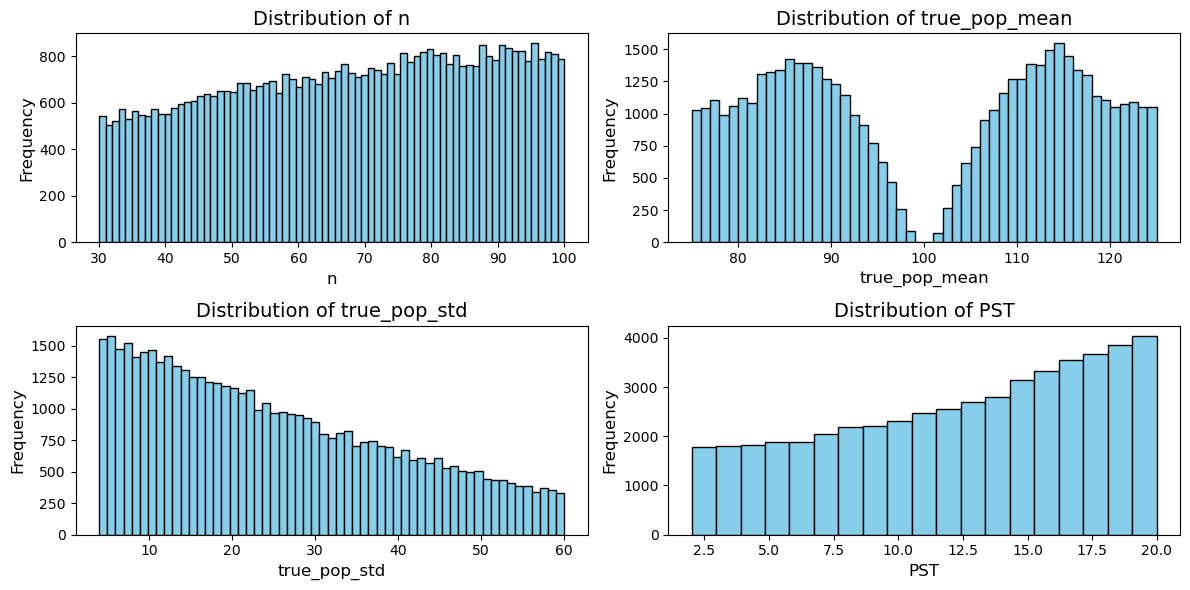

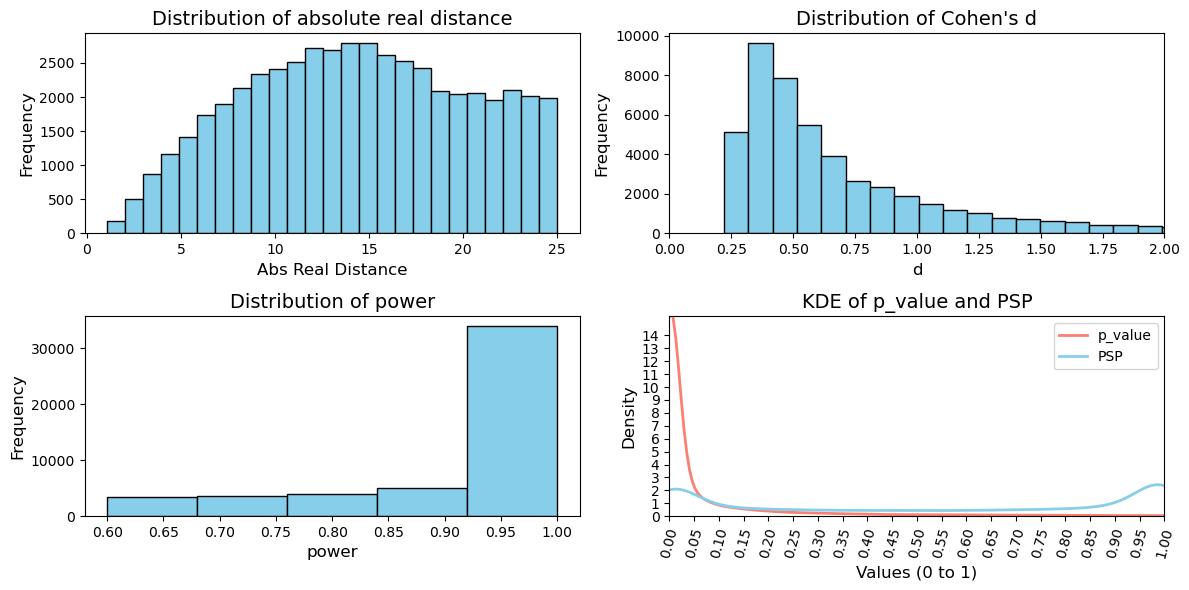

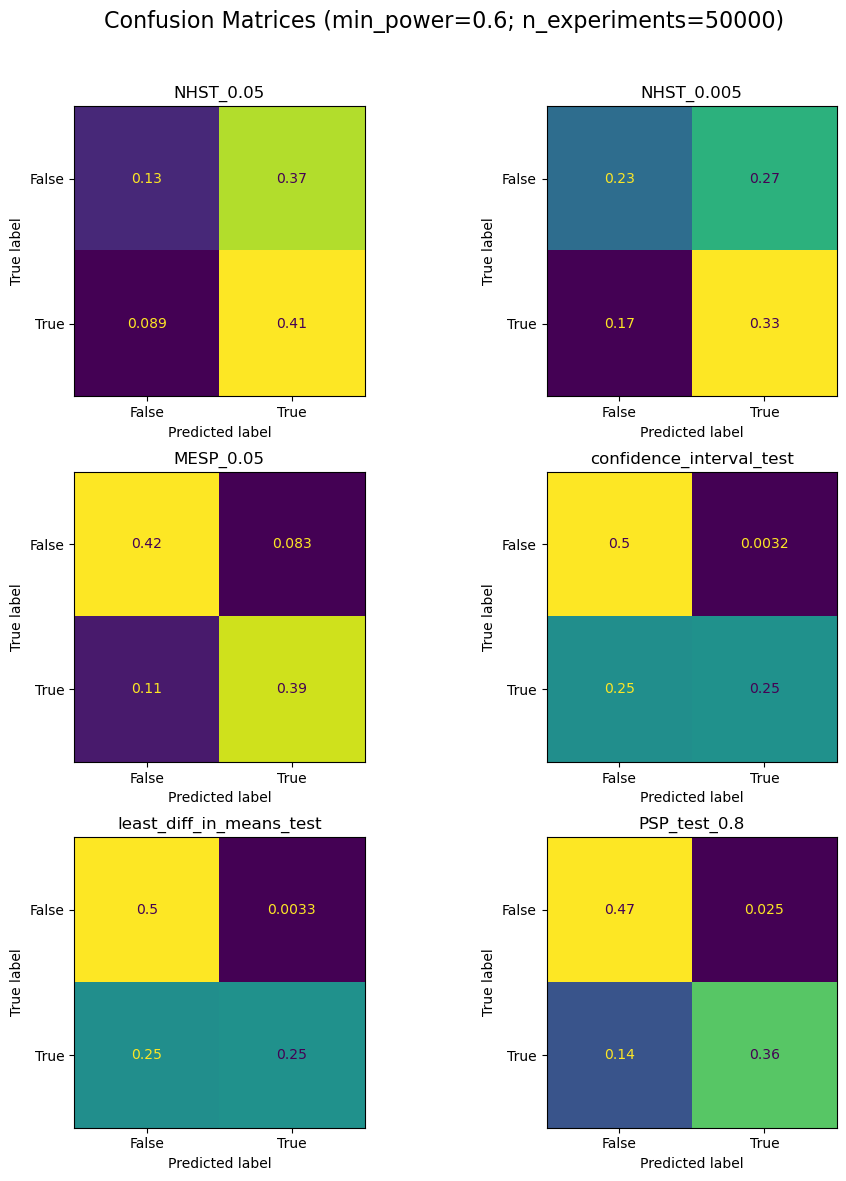

Test,TP,FP,TN,FN,TP%,FP%,TN%,FN%,FPR,F1
NHST_0.05,20545,18714,6286,4455,41.09,37.43,12.57,8.91,47.67,0.64
NHST_0.005,16467,13626,11374,8533,32.93,27.25,22.75,17.07,45.28,0.60
MESP_0.05,19638,4149,20851,5362,39.28,8.30,41.70,10.72,17.44,0.81
confidence_interval_test,12597,161,24839,12403,25.19,0.32,49.68,24.81,1.26,0.67
least_diff_in_means_test,12663,166,24834,12337,25.33,0.33,49.67,24.67,1.29,0.67
PSP_test_0.8,17920,1269,23731,7080,35.84,2.54,47.46,14.16,6.61,0.81


In [22]:
df, df_res = run_analysis(results, null_mean=null_mean, min_power=min_power)

In [ ]:
# Output example
df.sample(3)

,n,true_pop_mean,true_pop_std,observed_mean,observed_effect_size,observed_std,pst,power,p_value,interval,PSP,cohen_d,full_knowledge_reject_null,NHST_0.05,NHST_0.005,MESP_0.05,confidence_interval_test,least_diff_in_means_test,PSP_test_0.8,decision_pattern
3741,94,76.571757,42.574647,68.0200,-31.9123,43.5357,13.4402,1.000,0.0000,"(-44.23203, -19.59254)",0.9985,-0.55,True,True,True,True,True,True,True,1111111
6505,89,83.513141,52.737241,87.8506,-13.4302,50.3528,17.1128,0.835,0.0751,"(-28.23286, 1.37251)",0.3117,-0.31,False,False,False,False,False,False,False,0000000
44683,45,107.039330,20.540823,106.8032,2.8665,21.8472,11.7921,0.622,0.5347,"(-6.27308, 12.00602)",0.0261,0.34,False,False,False,False,False,False,False,0000000


### PSP_alpha study

We explore how different values for `PSP_alpha` affect decisions. Then, we check confusion matrices at each alpha level.

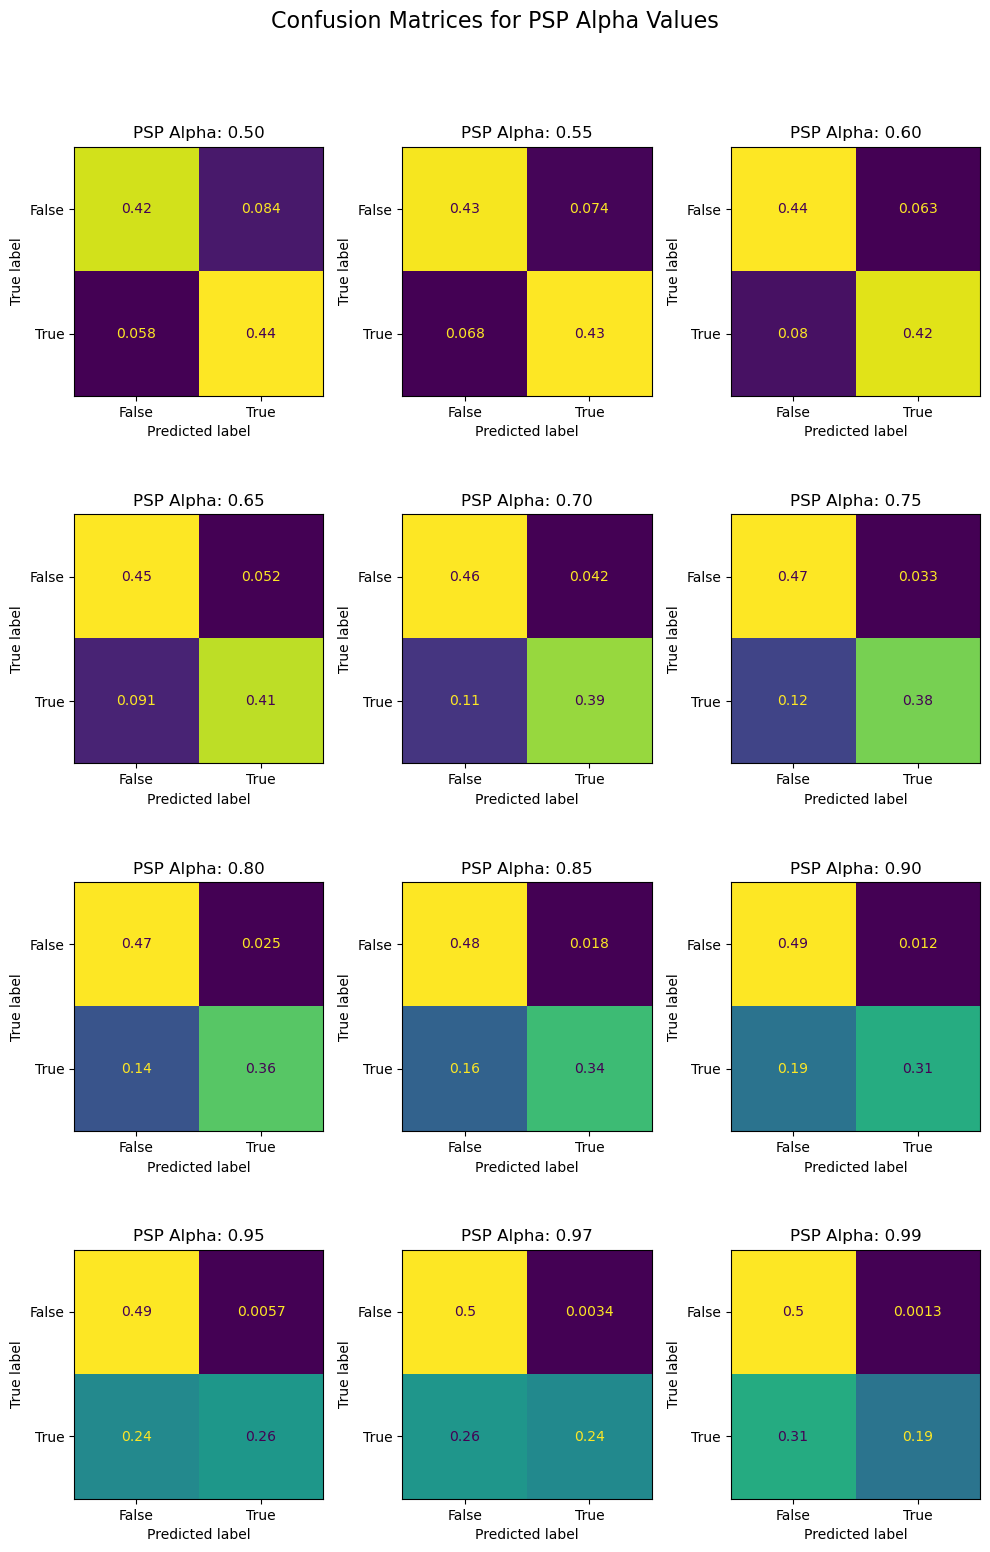

In [24]:
psp_alpha_values = np.array(list(np.arange(0.5, 1, 0.05)) + [0.97, 0.99])
# Set up the subplot grid
ncols = 3
nrows = int(np.ceil(len(psp_alpha_values) / ncols))  # Calculate rows based on number of alpha values
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows * 4))
fig.suptitle(f"Confusion Matrices for PSP Alpha Values", fontsize=16)

# Flatten axes for easier iteration
axes = axes.flatten()
# Plot confusion matrices
tests_analysis = {}
for i, psp_alpha in enumerate(psp_alpha_values):
  # Create psp_test column based on current alpha
  psp_test = df['PSP'].apply(lambda psp: bool(psp >= psp_alpha))
  # Calculate confusion matrix
  cm = confusion_matrix(df['full_knowledge_reject_null'], psp_test)
  tests_analysis[psp_alpha] = cm
  cm = cm / len(df)  # Normalize by the number of experiments
  # Plot the confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
  disp.plot(ax=axes[i], colorbar=False)
  axes[i].set_title(f"PSP Alpha: {psp_alpha:.2f}")

# Hide any unused subplots
for i in range(len(psp_alpha_values), len(axes)):
  axes[i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust for the title
plt.show()

### Statistical methods correlations

We look at how each test's decisions correlate (0 or 1) with each other.

In [25]:
COL_FIRST_METHOD = 12
COL_LAST_METHOD = 19
correlation_matrix = df[df.columns[COL_FIRST_METHOD:COL_LAST_METHOD]].corr()

# Find highly correlated pairs
high_correlation_pairs = []
threshold = 0  # set threshold for high correlation if necessary
for i, column in enumerate(correlation_matrix.columns):
  for j in range(i + 1, len(correlation_matrix.columns)):
    corr_value = correlation_matrix.iloc[i, j]
    if abs(corr_value) > threshold:  
      high_correlation_pairs.append(
        (correlation_matrix.index[i], correlation_matrix.columns[j], corr_value)
      )

# Convert results to a DataFrame for better visualization
high_corr_df = pd.DataFrame(
    high_correlation_pairs, columns=["Column 1", "Column 2", "Correlation"]
)

display(HTML(high_corr_df.style.background_gradient(cmap='summer').set_table_styles([
  {'selector': 'th', 
  'props': [('border', '1px solid gray'), 
            ('background-color', '#000'),
            ('color', '#fff'),
            ('font-weight', 'bold')]},
  {'selector': 'td', 
  'props': [('border', '1px solid #ddd')]}
]).format(precision=2).hide(axis="index").to_html()))

Column 1,Column 2,Correlation
full_knowledge_reject_null,NHST_0.05,0.09
full_knowledge_reject_null,NHST_0.005,0.12
full_knowledge_reject_null,MESP_0.05,0.62
full_knowledge_reject_null,confidence_interval_test,0.57
full_knowledge_reject_null,least_diff_in_means_test,0.57
full_knowledge_reject_null,PSP_test_0.8,0.68
NHST_0.05,NHST_0.005,0.64
NHST_0.05,MESP_0.05,0.50
NHST_0.05,confidence_interval_test,0.16
NHST_0.05,least_diff_in_means_test,0.17


Finally, we check correlations between a "PSP decision" (True/False) at various alpha values and the other methods.

In [26]:
# Define the other statistical method columns (these exclude the PSP test column)
other_methods = df.columns[COL_FIRST_METHOD:COL_LAST_METHOD-1]

psp_corr_results = {}
for psp_alpha in psp_alpha_values:
  psp_test = (df['PSP'] >= psp_alpha).astype(int)
  # Compute correlation between the current PSP test result and each other method
  corr = df[other_methods].apply(lambda col: col.corr(psp_test))
  psp_corr_results[psp_alpha] = corr

# Convert the dictionary to a DataFrame for better visualization
psp_corr_df = pd.DataFrame(psp_corr_results).T
psp_corr_df.index.name = 'PSP Alpha'
psp_corr_df.columns.name = 'Method'

# Optionally display the results with a background gradient
display(HTML(
  psp_corr_df.style.background_gradient(cmap='summer')
  .set_table_styles([
    {'selector': 'th', 
      'props': [('border', '1px solid gray'), 
                ('background-color', '#000'),
                ('color', '#fff'),
                ('font-weight', 'bold')]}
  ])
  .format(precision=2)
  .to_html()
))


Method,full_knowledge_reject_null,NHST_0.05,NHST_0.005,MESP_0.05,confidence_interval_test,least_diff_in_means_test
PSP Alpha,,,,,,
0.500000,0.72,0.31,0.28,0.90,0.49,0.50
0.550000,0.72,0.31,0.29,0.88,0.51,0.52
0.600000,0.72,0.32,0.31,0.86,0.53,0.54
0.650000,0.71,0.32,0.32,0.84,0.55,0.56
0.700000,0.71,0.33,0.33,0.81,0.58,0.58
0.750000,0.70,0.33,0.35,0.79,0.60,0.61
0.800000,0.68,0.34,0.37,0.77,0.64,0.64
0.850000,0.66,0.34,0.38,0.74,0.67,0.68
0.900000,0.63,0.34,0.39,0.70,0.73,0.74


### Convert decision patterns count to Overleaf table

The following code is used only to generate a LaTeX-style table to copy for Overleaf.

In [47]:
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

methods = df.columns[12:19]
table_markdown = ""
row_count = 1
for decision_pattern, count in df.decision_pattern.value_counts().to_dict().items():
  reject_nh = []
  not_reject_nh = []
  for method_i, test_result in enumerate(decision_pattern):
    reject = True if test_result == "1" else False
    if reject:
      reject_nh.append(methods[method_i])
    else:
      not_reject_nh.append(methods[method_i])

  reject_nh_cell = "\makecell{" + "\\\\".join(reject_nh).replace("_", "\_") + "}"
  not_reject_nh_cell = "\makecell{" + "\\\\".join(not_reject_nh).replace("_", "\_") + "}"
  count_cell = "\makecell{" + f"{count}\\\\({round(count/n_experiments*100,1)}\%)" + "}"

  table_markdown += f"{row_count} & {bool(decision_pattern[0] == "1")} & {reject_nh_cell} & {not_reject_nh_cell} & {count_cell} \\\\ \hline \n"
  row_count += 1

Print `table_markdown` and copy the content to Overleaf.

In [45]:
print(table_markdown)

1 & True & \makecell{full\_knowledge\_reject\_null\\NHST\_0.05\\NHST\_0.005\\MESP\_0.05\\confidence\_interval\_test\\least\_diff\_in\_means\_test\\PSP\_test\_0.8} & \makecell{} & \makecell{10895\\(21.8\%)} \\ \hline 
2 & False & \makecell{NHST\_0.05\\NHST\_0.005} & \makecell{full\_knowledge\_reject\_null\\MESP\_0.05\\confidence\_interval\_test\\least\_diff\_in\_means\_test\\PSP\_test\_0.8} & \makecell{10324\\(20.6\%)} \\ \hline 
3 & False & \makecell{} & \makecell{full\_knowledge\_reject\_null\\NHST\_0.05\\NHST\_0.005\\MESP\_0.05\\confidence\_interval\_test\\least\_diff\_in\_means\_test\\PSP\_test\_0.8} & \makecell{6255\\(12.5\%)} \\ \hline 
4 & False & \makecell{NHST\_0.05} & \makecell{full\_knowledge\_reject\_null\\NHST\_0.005\\MESP\_0.05\\confidence\_interval\_test\\least\_diff\_in\_means\_test\\PSP\_test\_0.8} & \makecell{4241\\(8.5\%)} \\ \hline 
5 & True & \makecell{full\_knowledge\_reject\_null\\NHST\_0.05\\NHST\_0.005\\MESP\_0.05\\PSP\_test\_0.8} & \makecell{confidence\_interva